In [ ]:
#Connect our notebook to the drive where the d2l folder exist to import it later
try:
    from google.colab import drive
    drive.mount('/gdrive', force_remount=True)
    import sys
    sys.path.append('/gdrive/MyDrive/Colab Notebooks')
except:
    pass

Mounted at /gdrive


In the following 2 cells, we made a custom function to import the dataset taking as an example the function from d2l to import the fashion minst dataset. In order for the out function to work, we also had to import and recreate some of the functions and libraries from the d2l code as well. 

In [ ]:
#@title Import Libraries
import d2l

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import functools
import numbers
from IPython import display
import time

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn



import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)

#Dataloader

In [ ]:


def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4
    
def load_data_KMNIST_mnist(batch_size, resize=None):
    """Download the KMNIST-MNIST dataset and then load it into memory.

    Defined in :numref:`KMNIST`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.KMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.KMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))



#Steming 

In the following cell we use the function unforld to divides the image into Np non-overlapping patches where each patch pi,j has dimensions KxK

In [ ]:
#Block Stem containes all the preperation of our data. We used function unfold to 
#break the images of size 32x32 to 32 smaller images of it self with a size of 4x4.
#and also it make the images into vector of 1x16.We passed them though a linear 
# layer a bach normalization and a relu activation function 
class Stem(nn.Module):
    def __init__(self):
        super(Stem, self).__init__()

        self.add_module('Steming', nn.Unfold(kernel_size=(4 , 4),stride=4 ))#We use stride=4 to keep our blocks from overlapping
        self.add_module('Linear', nn.Linear(16, 32))
        self.add_module('batchnorm',nn.BatchNorm1d(64))
        self.add_module('relu', nn.ReLU())

        
    def forward(self, x):
        out = x
        out = self._modules['Steming'](out)
        out= torch.permute(out, (0,2,1))
        out = self._modules['Linear'](out)
        out=self._modules['batchnorm'](out)
        out = self._modules['relu'](out)

        
        
        return out

#BackBone

In [ ]:
#block 1 has the first MLD from that we saw in the slides for the coursework
#It has a linear layer that takes input and intermidiate channels,
#a Relu activation function and another Linear layer at the end that that takes intermidiate and intermidiate channels. 
class Block1(nn.Module):
    def __init__(self, input_channels, intermediate_channels, stride=1 ):
        super(Block1, self).__init__()
        
        self.input_channels = input_channels
        self.output_channels = intermediate_channels

        self.add_module('Linear1', nn.Linear(input_channels, intermediate_channels))
        self.add_module('relu', nn.ReLU())
        self.add_module('Linear2', nn.Linear(intermediate_channels, intermediate_channels))
        
        
    def forward(self, x):
        x=torch.transpose(x, 0, 1)
        out= x
        out = self._modules['Linear1'](out)
        out = self._modules['relu'](out)
        out = self._modules['Linear2'](out)
        return out

In [ ]:
#block 2 has the second MLD from that we saw in the slides for the coursework
#It has a linear layer that takes intermidiate and intermidiate channels,
#a Relu activation function and another Linear layer at the end that that takes intermidiate and input channels (as the output channels). 
class Block2(nn.Module):
    def __init__(self, input_channels, intermediate_channels, stride=1 ):
        super(Block2, self).__init__()
        
        self.input_channels = input_channels
        self.output_channels = intermediate_channels

        self.add_module('relu', nn.ReLU())
        self.add_module('Linear3', nn.Linear(intermediate_channels, intermediate_channels))
        self.add_module('Linear4', nn.Linear(intermediate_channels, input_channels))
        
    def forward(self, x):
        x=torch.transpose(x, 0, 1)
        out= x
        out = self._modules['Linear3'](out)
        out = self._modules['relu'](out)
        out = self._modules['Linear4'](out)
        
        
        return out

In [ ]:
#In this cell we create a macro block containing both block 1 and block 2 
# At the end of each macroblock we add a recurent function by adding to our output the input and after that we use a relu activation function 
class MacroBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MacroBlock, self).__init__()
        
        self.add_module('Block1', Block1(in_channels, out_channels))
        self.add_module('Block2', Block2(in_channels, out_channels))
        self.add_module('relu', nn.ReLU())
        
    def forward(self, x):
        out = x
        out = self._modules['Block1'](out)
        out = self._modules['Block2'](out)
        out=out+x
        out = self._modules['relu'](out)
        

        return out

#Bulding the Network and adding a classifier

In [ ]:
#Here we compining the steming, macro block and a classifier at the end. After 
#tries with different number of macroblock we found that 5 macro blocks offer a good accuracy 
#without taking too much time to run.

class Nikolas_Net(nn.Module):
    def __init__(self):
        super(Nikolas_Net, self).__init__()
        #stem
        self.add_module('stem', Stem())
        #backbone
        self.add_module('MacroBlock1', MacroBlock(32, 64))
        self.add_module('MacroBlock2', MacroBlock(32, 128))
        self.add_module('MacroBlock3', MacroBlock(32, 256))
        self.add_module('MacroBlock4', MacroBlock(32, 512))
        #classification
        self.last = nn.Sequential(nn.Flatten(), nn.Linear(2048, 10))
        self.add_module('batchnorm', nn.BatchNorm1d(10))
        self.add_module('sigmoid', nn.Sigmoid())
        
        
    def forward(self, x):
        out = x
        out = self._modules['stem'](out)
        out = self._modules['MacroBlock1'](out)
        out = self._modules['MacroBlock2'](out)
        out = self._modules['MacroBlock3'](out)
        out = self._modules['MacroBlock4'](out)
        out = self.last(out)
        out = self._modules['batchnorm'](out)
        out = self._modules['sigmoid'](out)
        #print(out.shape)
        
        return out

In [ ]:
# Test your implementation here!
nikolas_net = Nikolas_Net()
batch_size = 64

train_iter, test_iter = load_data_KMNIST_mnist(batch_size, resize=32)
train_iter2 = iter(train_iter)
x = next(train_iter2)
y_hat = nikolas_net(x[0])

In [ ]:
#@title NetWork print
print(nikolas_net)

Nikolas_Net(
  (stem): Stem(
    (Steming): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=4)
    (Linear): Linear(in_features=16, out_features=32, bias=True)
    (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (MacroBlock1): MacroBlock(
    (Block1): Block1(
      (Linear1): Linear(in_features=32, out_features=64, bias=True)
      (relu): ReLU()
      (Linear2): Linear(in_features=64, out_features=64, bias=True)
    )
    (Block2): Block2(
      (relu): ReLU()
      (Linear3): Linear(in_features=64, out_features=64, bias=True)
      (Linear4): Linear(in_features=64, out_features=32, bias=True)
    )
    (relu): ReLU()
  )
  (MacroBlock2): MacroBlock(
    (Block1): Block1(
      (Linear1): Linear(in_features=32, out_features=128, bias=True)
      (relu): ReLU()
      (Linear2): Linear(in_features=128, out_features=128, bias=True)
    )
    (Block2): Block2(
      (relu): ReLU()
      (Linear3): Linear(in_fe

#Training the Network 

In [ ]:
#For the training of the network we use the code from lab 7 where we can specify  the machine we want to use, in our case is gpu
#and we also get 2 graphs, one for the loss and one for the training and validation accuracies. We also get the accuracy in each epoch 
#something that can show us if you are using too high learning rate or not. 
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device, ylim=(None, (0, 1))):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=ylim,
                        legend=[['train loss'], ['train acc', 'test acc']],
                        ncols=2, figsize=(7, 2.5))
    
    metric_dict = {}
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]

        
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        metric_dict[("Epoch "+str(epoch))] = 'training loss : '+str(round(train_loss, 3))+' ,train acc : '+str(round(train_acc, 3))+' ,test acc : '+str(round(test_acc, 3))
        print(f'training loss {train_loss:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}'+'\n')
        animator.add(epoch + 1, [train_loss, (train_acc, test_acc)])
        
    
    for each in metric_dict:
      print(each + " "+metric_dict[each] )

    print("")
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')
    print("")

In [ ]:
#We first train our model with a "high" learning rate to keep computation low
#We tried training with 64,128 and 256 batch size and found that 64 performed better. 
lr, num_epochs, batch_size = 0.5, 20, 64
train_iter, test_iter = load_data_KMNIST_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nikolas_net.parameters(), lr=lr)

Epoch 0 training loss : 1.719 ,train acc : 0.853 ,test acc : 0.765
Epoch 1 training loss : 1.596 ,train acc : 0.913 ,test acc : 0.781
Epoch 2 training loss : 1.567 ,train acc : 0.928 ,test acc : 0.828
Epoch 3 training loss : 1.553 ,train acc : 0.935 ,test acc : 0.772
Epoch 4 training loss : 1.544 ,train acc : 0.941 ,test acc : 0.848
Epoch 5 training loss : 1.537 ,train acc : 0.945 ,test acc : 0.871
Epoch 6 training loss : 1.532 ,train acc : 0.948 ,test acc : 0.875
Epoch 7 training loss : 1.528 ,train acc : 0.952 ,test acc : 0.873
Epoch 8 training loss : 1.525 ,train acc : 0.953 ,test acc : 0.874
Epoch 9 training loss : 1.522 ,train acc : 0.955 ,test acc : 0.883
Epoch 10 training loss : 1.519 ,train acc : 0.958 ,test acc : 0.881
Epoch 11 training loss : 1.517 ,train acc : 0.959 ,test acc : 0.884
Epoch 12 training loss : 1.515 ,train acc : 0.961 ,test acc : 0.875
Epoch 13 training loss : 1.513 ,train acc : 0.962 ,test acc : 0.881
Epoch 14 training loss : 1.511 ,train acc : 0.964 ,test ac

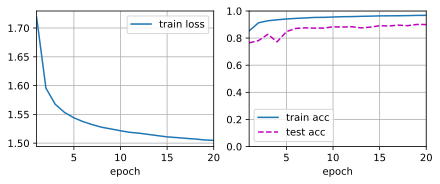

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(nikolas_net, train_iter, test_iter, loss, num_epochs, optimizer, device, ylim=(None, (0, 1)))

In [ ]:
#Now without initializing the network again we train our network for another 15 epoch 
#will lowering the learning rate to 0.1 to find a more precise solution

lr, num_epochs, batch_size = 0.1, 10, 64
train_iter, test_iter = load_data_KMNIST_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nikolas_net.parameters(), lr=lr)

Epoch 0 training loss : 1.492 ,train acc : 0.98 ,test acc : 0.905
Epoch 1 training loss : 1.492 ,train acc : 0.979 ,test acc : 0.901
Epoch 2 training loss : 1.492 ,train acc : 0.979 ,test acc : 0.903
Epoch 3 training loss : 1.491 ,train acc : 0.98 ,test acc : 0.905
Epoch 4 training loss : 1.491 ,train acc : 0.98 ,test acc : 0.905
Epoch 5 training loss : 1.491 ,train acc : 0.98 ,test acc : 0.903
Epoch 6 training loss : 1.491 ,train acc : 0.98 ,test acc : 0.905
Epoch 7 training loss : 1.491 ,train acc : 0.98 ,test acc : 0.902
Epoch 8 training loss : 1.49 ,train acc : 0.981 ,test acc : 0.905
Epoch 9 training loss : 1.49 ,train acc : 0.98 ,test acc : 0.905

7494.4 examples/sec on cuda



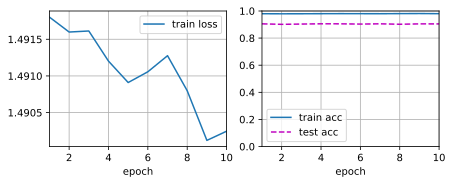

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(nikolas_net, train_iter, test_iter, loss, num_epochs, optimizer, device, ylim=(None, (0, 1)))